In [1]:
from dataManager.RainDataManager import RainDataManager
from dataManager.TempDataManager import TempDataManager
from dataManager.BikeDataManager import BikeDataManager
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates
from matplotlib import pylab as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

ImportError: cannot import name 'VirtualDeviceConfiguration'

In [27]:
#!pip install --upgrade tf-nightly tfp-nightly

    100% |████████████████████████████████| 108.6MB 5.9kB/s 
    100% |████████████████████████████████| 952kB 529kB/s 
Requirement already up-to-date: termcolor>=1.1.0 in /home/aritz/data/anaconda3/envs/tensorflow/lib/python3.5/site-packages (from tf-nightly)
    100% |████████████████████████████████| 17.2MB 39kB/s 
    100% |████████████████████████████████| 2.1MB 295kB/s 
    100% |████████████████████████████████| 61kB 1.8MB/s 
    100% |████████████████████████████████| 61kB 1.7MB/s 
    100% |████████████████████████████████| 491kB 846kB/s 
Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 3.1MB 208kB/s 
    100% |████████████████████████████████| 102kB 379kB/s 
    100% |████████████████████████████████| 61kB 1.9MB/s 
    100% |████████████████████████████████| 1.2MB 478kB/s 
Retrying (Retry(total=4, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionEr

In [22]:
num_forecast_steps = 7

In [2]:
rainDM = RainDataManager()
tempDM = TempDataManager()
bikeDM = BikeDataManager()

In [8]:
tempDM.loadData()
bikeDM.loadData()
rainDM.loadData()

In [4]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [17]:
start_date = date(2017, 1, 1)
end_date = datetime.now().date()
dates = []
bikes = []
temps = []
rains = []
for single_date in daterange(start_date, end_date):
    #print(str(single_date) + ' --> ' + str(bikeDM.getDayValue(single_date)))
    #print(type(single_date))
    dates.append(single_date)
    bikes.append(bikeDM.getDayValue(single_date))
    temps.append(tempDM.getDayValue(single_date))
    rains.append(rainDM.getDayValue(single_date))

No data for2019-04-27
No data for2019-04-28


In [18]:
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

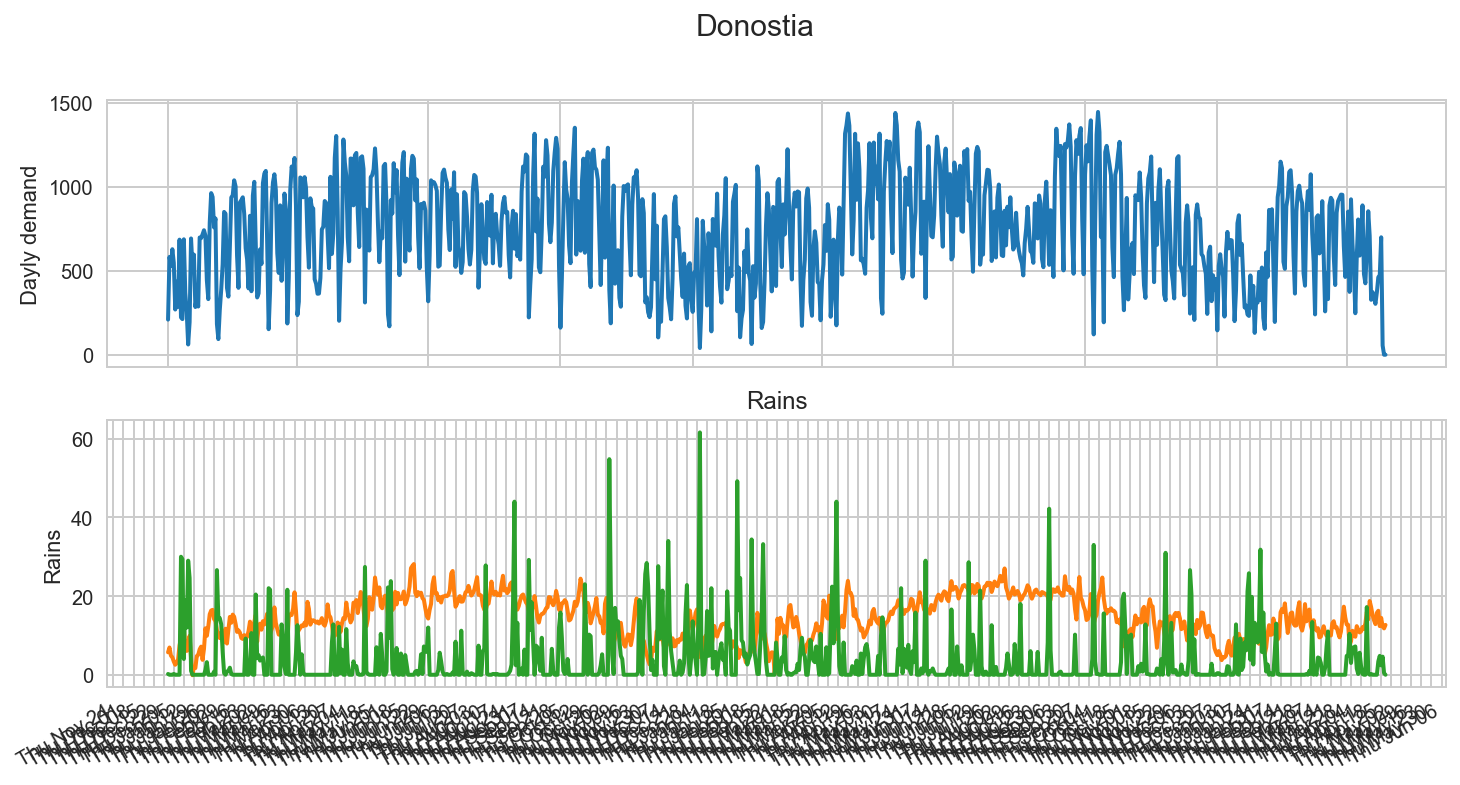

In [19]:
demand_loc = mdates.WeekdayLocator(3)
demand_fmt = mdates.DateFormatter('%a %b %d')

colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[2]

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(2, 1, 1)
ax.plot(dates,
        bikes, lw=2, label="Full data")
ax.set_ylabel("Dayly demand")

ax = fig.add_subplot(2, 1, 2)
ax.plot(dates,
        temps, lw=2, label="Full data", c=c2)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Temperature")

ax = fig.add_subplot(2, 1, 2)
ax.plot(dates,
        rains, lw=2, label="Full data", c=c3)
ax.set_ylabel("Rains")
ax.set_title("Rains")

ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Donostia",
             fontsize=15)
fig.autofmt_xdate()
plt.show()

fig.clear()
plt.close(fig)

In [23]:
#Split data sets 
dates_train = dates[:-num_forecast_steps]
dates_test = dates[-num_forecast_steps:]

bikes_train = bikes[:-num_forecast_steps]
bikes_test = bikes[-num_forecast_steps:]

temps_train = temps[:-num_forecast_steps]
temps_test = temps[-num_forecast_steps:]

rains_train = rains[:-num_forecast_steps]
rains_test = rains[-num_forecast_steps:]


In [24]:
def build_model(valuesP, tempsP):
  trend = sts.LocalLinearTrend(observed_time_series=valuesP)
  seasonal = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=valuesP)
  
  seasonal2 = tfp.sts.Seasonal(
      num_seasons=30, observed_time_series=valuesP)
  
  seasonal3 = tfp.sts.Seasonal(
      num_seasons=365, observed_time_series=valuesP)
  
  temperature_effect = tfp.sts.LinearRegression(
      design_matrix=tf.reshape(temps - np.mean(temps),
                               (-1, 1)), name='temperature_effect')
  rain_effect = tfp.sts.LinearRegression(
      design_matrix=tf.reshape(rains - np.mean(rains),
                               (-1, 1)), name='rain_effect')
  
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=valuesP, name='autoregressive')
  
  model = sts.Sum([ seasonal, seasonal2, temperature_effect, rain_effect, autoregressive ], observed_time_series=valuesP)
  return model

In [25]:
tf.reset_default_graph()
demand_model = build_model(bikes_train, temps_train)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      demand_model, bikes_train)
train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)

NameError: name 'tf' is not defined